In [2]:
import os
import pandas as pd
import pyarrow.parquet as pq

# Definir la ruta base
directory = "processed_data/2024-12-07"
output_file = f"{directory}.parquet"

# Lista para almacenar DataFrames
dataframes = []

# Recorrer las subcarpetas dentro de la carpeta principal
for subfolder in os.listdir(directory):
    subfolder_path = os.path.join(directory, subfolder)
    
    if os.path.isdir(subfolder_path):  # Verificar que sea una carpeta
        parquet_files = [f for f in os.listdir(subfolder_path) if f.endswith(".parquet")]
        
        for parquet_file in parquet_files:
            parquet_path = os.path.join(subfolder_path, parquet_file)
            df = pd.read_parquet(parquet_path)
            dataframes.append(df)

# Concatenar todos los DataFrames
df_final = pd.concat(dataframes, ignore_index=True)

# Guardar el resultado en un único archivo Parquet
df_final.to_parquet(output_file, index=False)

print(f"Parquet consolidado guardado en: {output_file}")


KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
from visualization.maps import Maps
import preprocess.utilities as ut
from preprocess.dataframe_processor import DataframeProcessor

DATA_PATH = "./primeraSemanaDash.parquet"
df = pd.read_parquet(DATA_PATH)

# Procesamos los datos de la forma adecuada
df = ut.stringToNan(df)

df.columns


/opt/anaconda3/envs/PD2/lib/python3.11/site-packages/movingpandas/__init__.py:41: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


Index(['Timestamp (date)', 'ICAO', 'Callsign', 'Flight status', 'Speed',
       'Altitude (ft)', 'lat', 'lon', 'Typecode', 'TurbulenceCategory',
       'Downlink Format', 'hour', 'day_of_week'],
      dtype='object')

In [4]:
import importlib
import preprocess.dataframe_processor as dp  

In [6]:
importlib.reload(dp)

<module 'preprocess.dataframe_processor' from '/Users/javimartinfuentes/Documents/GitHub/despegues/src/preprocess/dataframe_processor.py'>

In [8]:
import pandas as pd
import os

# Supongamos que ya tienes tu DataFrame df y DataframeProcessor definido

# Crear la carpeta 'wait' si no existe
output_dir = 'wait'
os.makedirs(output_dir, exist_ok=True)

# Agrupar por 'ICAO' y 'Callsign' y asignar un número de partición
df['partition'] = (df.groupby(['ICAO']).ngroup() % 10)



df['partition'].value_counts()

partition
3    28861065
2    27873538
6    27186400
4    26885832
1    26435674
5    26318824
0    25711504
8    25403615
9    25110980
7    24660882
Name: count, dtype: int64

In [7]:
df["Flight status"].value_counts()

Flight status
airborne     83459316
on-ground    36842731
Name: count, dtype: int64

In [1]:
# Guardar cada partición en un archivo Parquet aplicando DataframeProcessor.getWaitTimes
for partition_num in range(10):
    partition_df = df[df['partition'] == partition_num]
    print(partition_df.shape)
    
    # Aplicar DataframeProcessor.getWaitTimes a la partición
    processed_df = dp.DataframeProcessor.getWaitTimes(partition_df)

    print(processed_df.shape)
    
    # Eliminar la columna 'partition'
    if 'partition' in processed_df.columns:
        processed_df = processed_df.drop(columns=['partition'])
    
    # Definir la ruta del archivo Parquet
    partition_file_path = os.path.join(output_dir, f'partition_{partition_num}.parquet')
    
    # Guardar el DataFrame procesado en formato Parquet
    processed_df.to_parquet(partition_file_path, index=False)

print("Particiones procesadas y guardadas en formato Parquet en la carpeta 'wait'.")

NameError: name 'df' is not defined

In [4]:
import pandas as pd

In [14]:
import pandas as pd
import os

# Definir la carpeta donde están las particiones
output_dir = 'wait'

# Inicializar una lista para almacenar los DataFrames
dataframes = []

# Recorrer las particiones y cargar cada archivo Parquet
for partition_num in range(10):
    partition_file_path = os.path.join(output_dir, f'partition_{partition_num}.parquet')
    
    if os.path.exists(partition_file_path):
        partition_df = pd.read_parquet(partition_file_path)
        dataframes.append(partition_df)

# Combinar todos los DataFrames en uno solo
combined_df = pd.concat(dataframes, ignore_index=True)

# Guardar el DataFrame combinado en formato Parquet
combined_file_path = 'esperas.parquet'
combined_df.to_parquet(combined_file_path, index=False)

print("Todas las particiones han sido combinadas y guardadas en 'esperas.parquet'.")


Todas las particiones han sido combinadas y guardadas en 'esperas.parquet'.


In [3]:

combined_file_path = 'esperas.parquet'
df_espera = pd.read_parquet(combined_file_path)
df_espera.shape

(5313, 10)

In [4]:
df_tipos = DataframeProcessor.getAirplaneCategories(df)

In [18]:
df_aterrizajes = df_espera.merge(df_tipos, on="ICAO")

In [29]:
df_aterrizajes["TurbulenceCategory"].value_counts()

TurbulenceCategory
Medium 2 (between 34000 kg to 136000 kg)                         1405
Medium 1 (between 7000 kg and 34000 kg)                          1318
High vortex aircraft                                             1267
Heavy (larger than 136000 kg)                                     603
Light (less than 7000 kg)                                         291
High performance (>5 g acceleration) and high speed (>400 kt)     262
Ground obstruction                                                 15
Surface service vehicle                                             1
Name: count, dtype: int64

In [12]:
df_aterrizajes = df_aterrizajes[df_aterrizajes["Wait time (s)"] < 5000]

In [20]:
df_aterrizajes[df_aterrizajes["Wait time (s)"] > 5000].sort_values(by="Wait time (s)")

,Callsign,ICAO,ts ground,ts airborne,lat,lon,runway,Wait time,Wait time (s),day_of_week,TurbulenceCategory
1879,IBS1545_,3472C9,2024-12-07 11:15:44.234,2024-12-07 12:39:04.689,40.498627,-3.574646,3,0 days 01:23:20.455000,5000.455,Sat,Medium 2 (between 34000 kg to 136000 kg)
1361,IBS1831_,342188,2024-12-01 10:17:17.791,2024-12-01 11:41:13.105,40.506545,-3.559258,4,0 days 01:23:55.314000,5035.314,Sun,Medium 1 (between 7000 kg and 34000 kg)
4777,EVE813__,495168,2024-12-02 13:50:51.007,2024-12-02 15:15:33.436,40.497561,-3.574677,3,0 days 01:24:42.429000,5082.429,Mon,Medium 1 (between 7000 kg and 34000 kg)
4593,UAL3923_,AA44CD,2024-12-01 08:06:16.205,2024-12-01 09:31:28.886,40.497561,-3.574614,3,0 days 01:25:12.681000,5112.681,Sun,High vortex aircraft
1911,IBS16ZP_,347553,2024-12-02 18:51:02.788,2024-12-02 20:17:14.624,40.498166,-3.574677,3,0 days 01:26:11.836000,5171.836,Mon,High vortex aircraft
...,...,...,...,...,...,...,...,...,...,...,...
188,IBE0137_,346146,2024-12-01 14:07:27.294,2024-12-06 12:32:53.930,40.498032,-3.574646,3,4 days 22:25:26.636000,426326.636,Fri,Medium 1 (between 7000 kg and 34000 kg)
4801,GES101N_,347295,2024-12-01 11:17:41.772,2024-12-06 10:18:06.606,40.497665,-3.574646,3,4 days 23:00:24.834000,428424.834,Fri,Medium 2 (between 34000 kg to 136000 kg)
4638,AEA058__,346385,2024-12-02 04:37:14.516,2024-12-07 04:17:02.991,37.824966,-6.449910,3,4 days 23:39:48.475000,430788.475,Sat,Medium 2 (between 34000 kg to 136000 kg)
4101,WMT247__,4D24C4,2024-12-01 21:08:19.529,2024-12-07 21:15:17.597,40.505009,-3.559196,4,6 days 00:06:58.068000,518818.068,Sat,High vortex aircraft


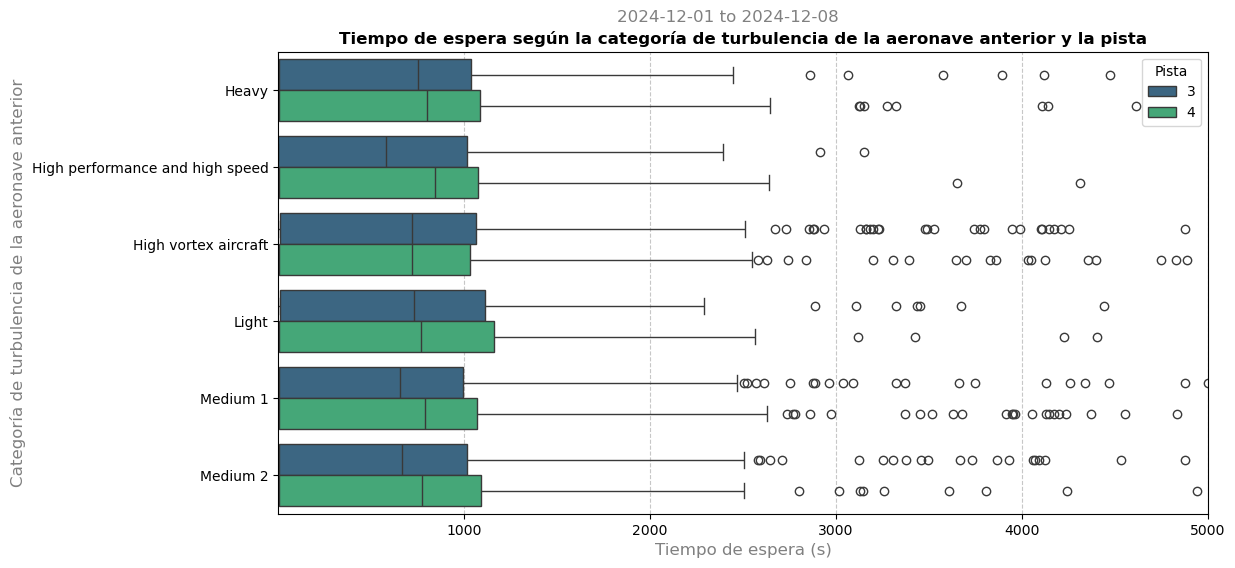

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_aterrizajes2 = df_aterrizajes.sort_values(by="ts airborne")

df_aterrizajes2["Prev_Turbulence"] = df_aterrizajes2.groupby("runway")["TurbulenceCategory"].shift(1)
df_aterrizajes2 = df_aterrizajes2.dropna(subset=["Prev_Turbulence"])

df_aterrizajes2["Prev_Turbulence"] = df_aterrizajes2["Prev_Turbulence"].str.replace(r'\s*\(.*?\)', '', regex=True)

df_aterrizajes2["Prev_Turbulence"] = pd.Categorical(
    df_aterrizajes2["Prev_Turbulence"], 
    categories=sorted(df_aterrizajes2["Prev_Turbulence"].unique()), 
    ordered=True
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_aterrizajes2,
    y="Prev_Turbulence",
    x="Wait time (s)",
    hue="runway",
    palette=sns.color_palette("viridis", n_colors=len(df_aterrizajes["runway"].unique()))
)

plt.title("Tiempo de espera según la categoría de turbulencia de la aeronave anterior y la pista", fontweight="bold")
plt.suptitle("2024-12-01 to 2024-12-08", fontsize=12, color="gray", y=0.95)
plt.xlabel("Tiempo de espera (s)", fontsize=12, color="gray")
plt.ylabel("Categoría de turbulencia de la aeronave anterior", fontsize=12, color="gray")
plt.legend(title="Pista")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(left=1, right=5000)
plt.show()


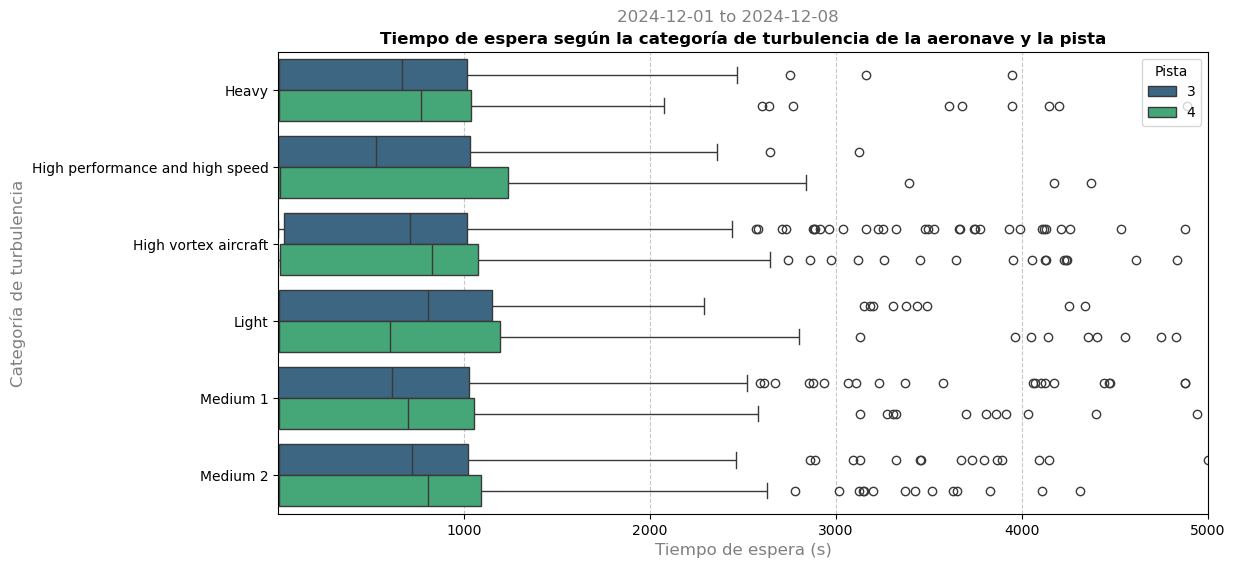

In [19]:
df_aterrizajes3 = df_aterrizajes.copy()

df_aterrizajes3["TurbulenceCategory"] = df_aterrizajes3["TurbulenceCategory"].str.replace(r'\s*\(.*?\)', '', regex=True)

df_aterrizajes3["TurbulenceCategory"] = pd.Categorical(
    df_aterrizajes3["TurbulenceCategory"], 
    categories=sorted(df_aterrizajes3["TurbulenceCategory"].unique()), 
    ordered=True
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_aterrizajes3,
    y="TurbulenceCategory",
    x="Wait time (s)",
    hue="runway",
    palette=sns.color_palette("viridis", n_colors=len(df_aterrizajes["runway"].unique()))
)

plt.title("Tiempo de espera según la categoría de turbulencia de la aeronave y la pista", fontweight="bold")
plt.suptitle("2024-12-01 to 2024-12-08", fontsize=12, color="gray", y=0.95)
plt.xlabel("Tiempo de espera (s)", fontsize=12, color="gray")
plt.ylabel("Categoría de turbulencia", fontsize=12, color="gray")
plt.legend(title="Pista", loc="upper right")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(left=1, right=5000)

plt.show()


/var/folders/dp/1z2xwn7516q1b4n5t3nlr0500000gn/T/ipykernel_7706/3626512461.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


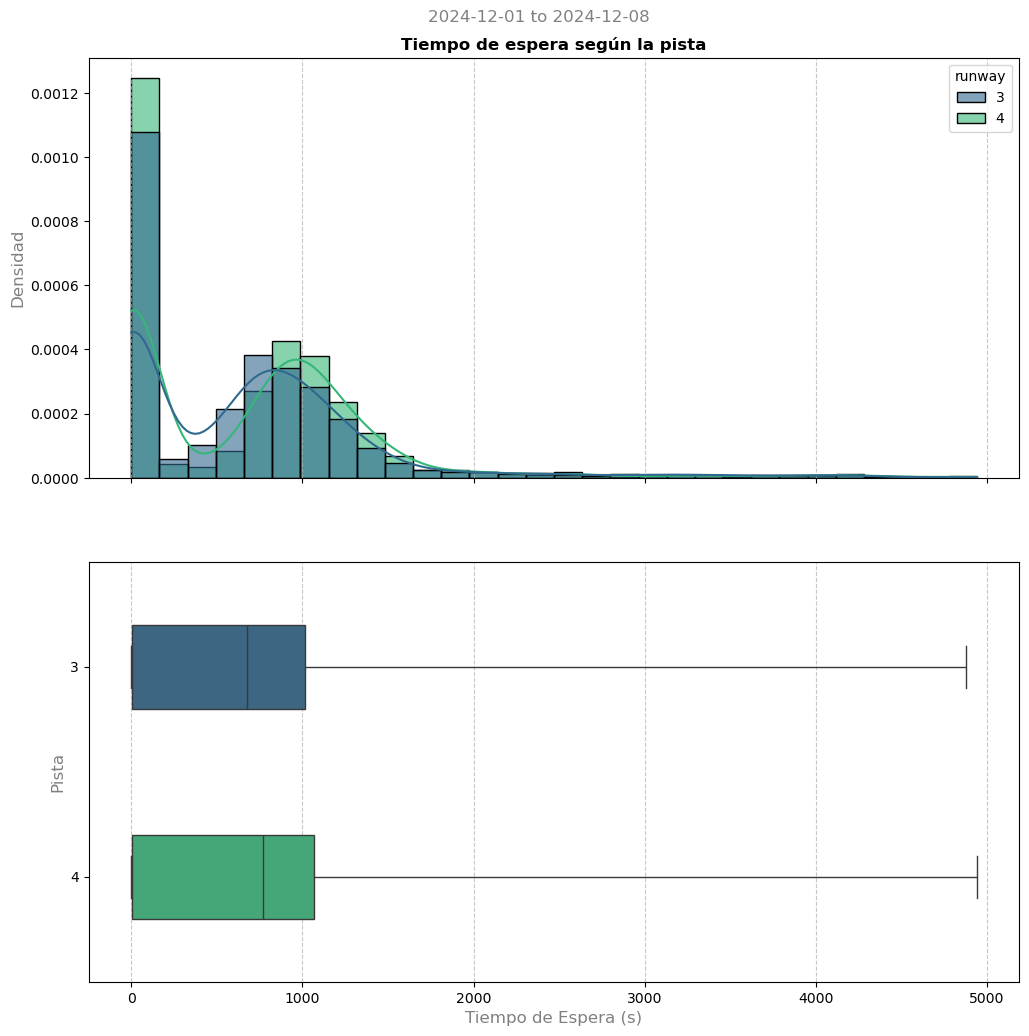

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configurar la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Crear el histograma por pista
sns.histplot(
    data=df_aterrizajes,
    x="Wait time (s)",
    hue="runway",
    kde=True,  # Añadir la estimación de densidad
    bins=30,  # Número de bins
    palette=sns.color_palette("viridis", n_colors=len(df_aterrizajes["runway"].unique())),
    alpha=0.6,
    stat="density",  # Usar densidad para normalizar el histograma
    ax=ax1  # Especificar el eje
)

ax1.set_title("Tiempo de espera según la pista", fontweight="bold")
ax1.set_ylabel("Densidad", fontsize=12, color="gray")
ax1.grid(axis="x", linestyle="--", alpha=0.7)

# Crear el boxplot
sns.boxplot(
    data=df_aterrizajes,
    x="Wait time (s)",
    y="runway",
    palette=sns.color_palette("viridis", n_colors=len(df_aterrizajes["runway"].unique())),
    whis=np.inf,  # Para mostrar todos los puntos
    width=0.4,  # Ancho del boxplot
    ax=ax2  # Especificar el eje
)

# Añadir títulos y etiquetas
ax2.set_xlabel("Tiempo de Espera (s)", fontsize=12, color="gray")
ax2.set_ylabel("Pista", fontsize=12, color="gray")
ax2.grid(axis="x", linestyle="--", alpha=0.7)
fig.suptitle("2024-12-01 to 2024-12-08", fontsize=12, color="gray", y=0.92)

plt.show()


In [3]:
Maps.positionsScatterMap(df, date="202002020202").save("pruebaaa.html")